1. Setup MarioAI

In [12]:
# !pip install gym_super_mario_bros nes-py

In [2]:
# import the Joypad wrapper
from nes_py.wrappers import JoypadSpace
#import the game 
import gym_super_mario_bros

# import the symplified controls
from gym_super_mario_bros.actions import SIMPLE_MOVEMENT

# import numpy as np


In [14]:
SIMPLE_MOVEMENT


[['NOOP'],
 ['right'],
 ['right', 'A'],
 ['right', 'B'],
 ['right', 'A', 'B'],
 ['A'],
 ['left']]

7 action the AI can make.

In [31]:
# Setup game
env = gym_super_mario_bros.make(
    'SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human")
env = JoypadSpace(env, SIMPLE_MOVEMENT)


c:\Users\sami\anaconda3\lib\site-packages\gym\envs\registration.py:627: UserWarning: WARN: The environment creator metadata doesn't include `render_modes`, contains: ['render.modes', 'video.frames_per_second']
  logger.warn(


In [32]:
# Create a flag - restart or not
done = True
# loop through each frame in game
for step in range (5000):
    if done:
        # start the game
        env.reset()
        
    # does random actions
    state, reward, done, truncated, info = env.step(env.action_space.sample())
    # render the game / show the game
    env.render()
#close the game
env.close()

c:\Users\sami\anaconda3\lib\site-packages\gym_super_mario_bros\smb_env.py:148: RuntimeWarning: overflow encountered in scalar subtract
  return (self.ram[0x86] - self.ram[0x071c]) % 256



bounding frame of the game 240x256 pixels



 info returned from game environment
env.step(1)[4]

{'coins': 0,
 'flag_get': False,
 'life': 2,
 'score': 0,
 'stage': 1,
 'status': 'small',
 'time': 400,
 'world': 1,
 'x_pos': 40,
 'x_pos_screen': 40,
 'y_pos': 79}


2. Preprocess the Environment

In [2]:
# !pip install stable_baselines3

# install pytorch
# !pip3 install torch torchvision torchaudio --index-url https://download.pytorch.org/whl/cu121
# !pip install stable_baselines3[extra]

In [3]:
# Import Frame stacker Warpperr and GreyScaling Warpper to help with the training

from gym.wrappers import GrayScaleObservation
#import Vectorize warpper 
from stable_baselines3.common.vec_env import DummyVecEnv, VecFrameStack  

#import Matplotlib
from matplotlib import pyplot as plt

In [8]:
# Create Base Environment
# 1. Create the environment
env = gym_super_mario_bros.make(
    'SuperMarioBros-v0', apply_api_compatibility=True, render_mode="human")
# 2. simplifity the controls
env = JoypadSpace(env, SIMPLE_MOVEMENT)
# 3. apply greyscale
env = GrayScaleObservation(env, keep_dim=True)
# 4. Wrap inside dummy enviroment

# 5. Stack frames

Reasons for Grayscale are the redused prosseing power required to train the model.
(240, 256, 3) -> Colour image
(240, 256, 1) -> Grayscale image

240x256x1 = 61440 pixels
240x256x3 = 184320 pixels

thus a substantial reduction in the number of pixels to process.

In [9]:
state =env.reset()


In [11]:
state[0].shape

(240, 256, 1)

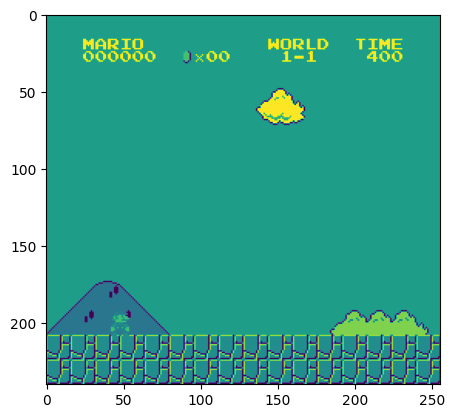

In [10]:
# use matplotlib to show the game frame
plt.imshow(state[0])

3. Train RL Model

4. Test RL Model